In [1]:
import numpy as np
import pandas as pd
from ase import Atoms
from ase import neighborlist
from ase import units
from ase.io.trajectory import Trajectory
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.api import qqplot
from scipy import stats
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
#from sktime.forecasting.arima import AutoARIMA, ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import seaborn as sns


plt.rc('font', family="sans-serif", weight="bold")          # controls default text sizes
plt.rc('axes', labelsize=15, titlesize=15)    # x and y axes
plt.rc('xtick', labelsize=15)    # Major Ticks
plt.rc('ytick', labelsize=15)    # Major Ticks
plt.rc('xtick.minor', visible=True)    # Minor Ticks
plt.rc('ytick.minor', visible=True)    # Minor Ticks
plt.rc('legend', fontsize=10)    # Legend
plt.rc('figure', titlesize=10)  # Figure title


plt.rcParams['figure.dpi'] = 300
print(plt.rcParams['font.family'])

['sans-serif']


In [18]:
force_df = pd.read_csv("Data/Model_test/Moldyn_dataframe_data.csv")
force_df = force_df[20:]
atoms = ["C1", "C2", "O", "H1", "H2", "H3", "H4", "H5", "H6"]

# Compare OLS and ARIMA

c:\Users\birk\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
c:\Users\birk\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
42   NaN
43   NaN
44   NaN
45   NaN
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                   O(x)   No. Observations:                    6
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  -0.668
Date:                Thu, 07 Mar 2024   AIC                              7.336
Time:                        14:09:08   BIC                              6.711
Sample:                             0   HQIC                             4.835
                                  - 6                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const (fi

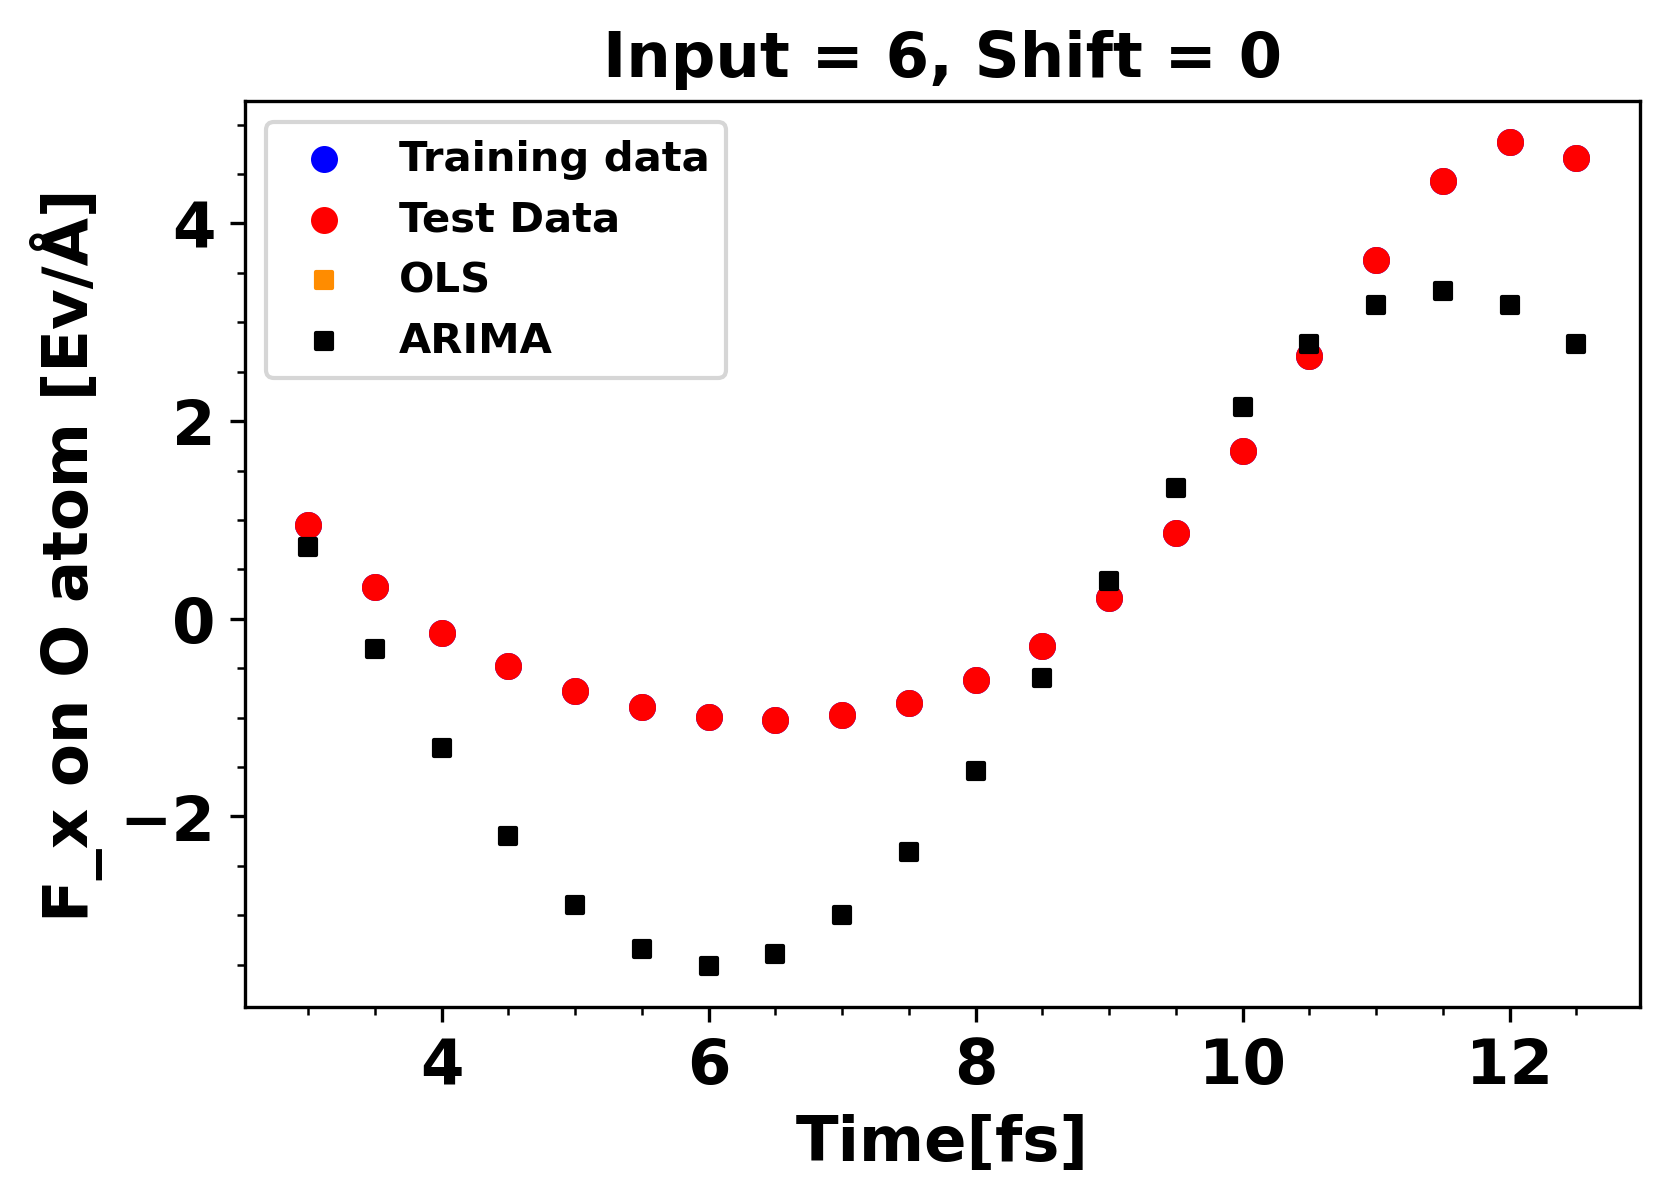

In [22]:
def create_OLS_model(time_series, order=2):
    input = len(time_series)-order
    X = np.zeros([input,order+1])
    for i in range(order):
        #print(time_series.shift(i+1)[i+1:len(time_series)-order+i+1])
        X[:,i] = time_series[i:input+i]
    X[:,-1] = np.ones(len(time_series)-order)
    return sm.OLS(time_series[order:], X)

input = 6
shift = 0
pred_step = 20


columns = force_df.drop('Unnamed: 0', axis=1).columns.values.tolist()
X = np.zeros([4, 3])
X[:,0] = force_df['O(x)'][shift:shift+input-2]
X[:,1] = force_df['O(x)'][shift+1:shift+input-1]
X[:,2] = np.ones(input-2)
#OLS_model = sm.OLS(force_df['O(x)'][2:input], X).fit()
OLS_model = AutoReg(force_df['O(x)'][shift:shift+input], 2).fit(cov_type="HC0")#, cov_kwds={"maxlags":2}, use_t=True)
pred_OLS = OLS_model.predict(start=shift+input, end=shift+input+pred_step-1) 
print(pred_OLS)
OLS_res = np.abs(pred_OLS-force_df['O(x)'][input:input+pred_step])
#print(OLS_model.summary())


# pred_OLS = np.zeros(pred_step+2)
# pred_OLS[:2] = force_df['O(x)'][shift+input-2:shift+input]

# for i in range(pred_step):
#     X = np.array([pred_OLS[i], pred_OLS[i+1],  1])
#     pred_OLS[i+2] = OLS_model.predict(X)

#OLS_res = abs(pred_OLS[2:]-force_df['O(x)'][input:input+pred_step])
arma_mod = ARIMA(force_df['O(x)'][shift:shift+input], order=(2, 0, 0))
with arma_mod.fix_params({'const': 0}):
        arma_mod = arma_mod.fit()

pred_arma = arma_mod.predict(start=input+shift, end=shift+input+pred_step-1) 
arma_res = np.abs(pred_arma-force_df['O(x)'][shift+input:shift+input+pred_step])

print(arma_mod.summary())
force_O = np.array([force_df['O(x)'], force_df['O(y)'], force_df['O(z)']])
plt.scatter(np.arange(input+shift, input+shift+pred_step)*0.5, force_df['O(x)'][shift+input:input+shift+pred_step], color="Blue", label="Training data", s=30)
plt.scatter(np.arange(input+shift, input+shift+pred_step)*0.5, force_df['O(x)'][shift+input:input+shift+pred_step], color="Red", label="Test Data", s=30)
plt.scatter(np.arange(input+shift, input+shift+pred_step)*0.5, pred_OLS, label="OLS", s=15, marker="s", color="darkorange")
plt.scatter(np.arange(input+shift, input+shift+pred_step)*0.5, pred_arma, label="ARIMA", s=15, marker="s", color="Black")
plt.title("Input = "+str(input)+", Shift = "+str(shift), fontweight="bold")
plt.xlabel("Time[fs]", fontweight="bold")
plt.ylabel("F_x on O atom [Ev/Å]", fontweight="bold")
plt.legend()
plt.show()